In [3]:
import time_series_pred_model

import torch

data = torch.load("items.json")


## Основной целью данного jupyter файла является проверка и тестирование эффективности и работоспособности нашей модели, которая способна предсказывать временные ряды с помощью преобразований Фурье.
### Для начала, подготовим данные.

In [4]:
import pandas as pd
import random
# sample_items = random.sample(list(data.items()), 10)
# for key, value in sample_items:
#     print(key, value)

df_tensor = pd.DataFrame.from_dict(data, orient='index')

# Функция для извлечения тензора из value словаря
def extract_tensor(x):
    if isinstance(x, dict):
        return pd.Series(x).apply(extract_tensor)
    elif isinstance(x, torch.Tensor):
        return x
    else:
        return None

# Применение функции к каждому элементу DataFrame и преобразование в Series
s = df_tensor.applymap(extract_tensor).stack()

print(s)

4D5CF815F5D9F81391510D421CF567EF  prices    [tensor(1000000.), tensor(1000000.), tensor(10...
                                  cnt       [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1A1D8A4A6BD5E56958128A32B086A2C0  prices    [tensor(1000000.), tensor(1000000.), tensor(11...
                                  cnt       [tensor(0.), tensor(0.), tensor(1.), tensor(0....
3506A17DB897B0F35F01FBD6983B94F4  prices    [tensor(1000000.), tensor(1000000.), tensor(10...
                                                                  ...                        
BA0C00625E89155A74FEB264E3371410  cnt       [tensor(0.), tensor(0.), tensor(0.), tensor(0....
978FC8C0D9486076C4DB7CFBF568ED09  prices    [tensor(1000000.), tensor(1000000.), tensor(10...
                                  cnt       [tensor(0.), tensor(0.), tensor(0.), tensor(0....
8E6D567CB89FE0A58503EB17042E1920  prices    [tensor(73571.3359), tensor(41383.8750), tenso...
                                  cnt       [tensor(3.), ten

In [5]:
# получаем список тензоров для ключа "a"
tensor_list = [v["cnt"] for v in data.values() if isinstance(v["cnt"], torch.Tensor)]

# создаем серию из списка тензоров
tensor_series = pd.Series(tensor_list)

print(tensor_series)

0       [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1       [tensor(0.), tensor(0.), tensor(1.), tensor(0....
2       [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3       [tensor(8.), tensor(3.), tensor(3.), tensor(2....
4       [tensor(0.), tensor(0.), tensor(0.), tensor(0....
                              ...                        
9084    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9085    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9086    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9087    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9088    [tensor(3.), tensor(8.), tensor(11.), tensor(7...
Length: 9089, dtype: object


### Как мы уже проанализировали до этого момента, одним из самым популярным и покупаемым продуктом является продукт с gtin-ом, приведённым ниже. Занесём его в отдельную переменную и именно на нём протестируем нашу модели

In [19]:

most_popular_product_tensor = data["1AF3D5B9E053CBDF908FB967FE3543AA"]['cnt']
print(most_popular_product_tensor)

tensor([ 39.,  45.,  58.,  54., 121., 142., 134.,  65.,  56.,  43.,  41.,  51.,
         73.,  52.,  42.,  44.,  43.,  80.,  69.,  87.,  98.,  56.,  57.,  72.,
         69.,  96., 127., 158.,  71.,  92.,  94., 116., 146., 175., 192., 170.,
        203., 263., 352., 299.,  14.,  36.,  29.,  29.,  30.,  37.,  18.,  22.,
         18.,  20.,  10.,  23.,  19.,  35.,  51.,  41.,  21.,  21.,  34.,  33.,
         44.,  31.,  36.,  19.,  24.,  16.,  26.,  32.,  29.,  40.,  28.,  24.,
         37.,  39.,  54.,  64.,  73.,  45.,  40.,  66.,  66.,  79., 118.,  99.,
        128.,  85.,  91., 101., 125., 170., 201., 253., 523., 565.,  99.,  91.,
        130., 123.,  64.,  23.,  24.,  29.,  32.,  48.,  57.,  51.,  47.,  36.,
         38.,  49.,  47.,  62.,  21.,  28.,  39.,  42.,  24.,  29.,  33.,  21.,
         14.,  17.,  19.,  20.,  30.,  37.,  16.,  20.,  27.,  14.,  22.,  28.,
         24.,  13.,  20.,  13.,  32.,  28.,  39.,  41.,  19.,  17.,  27.,  15.,
         34.,  43.,  38.,  19.,  24.,  1

In [20]:
def split_tensor_for_time_series(tensor):
    tensor_split = torch.split(tensor, int(len(tensor)*0.8), dim=0)
    return pd.Series(tensor_split[0]), pd.Series(tensor_split[1])


time_series_model = time_series_pred_model.Time_series_model(4, 73, 1) # 4 периода по 73 дня.
# Предсказывает следующий период длины 73. Можно поменять и сделать периодов больше длины 5 дней
# И тогда будет предсказывать следующие 5 дней

train_cnt, test_cnt = split_tensor_for_time_series(most_popular_product_tensor)


time_series_model.fit(train_cnt)


In [21]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_pred = time_series_model.predict(test_cnt)
mae = round(mean_absolute_error(test_cnt, test_pred), 2)
mape = round(mean_absolute_percentage_error(test_cnt, test_pred), 3)
print("MAE:", mae)
print("MAPE:", mape)

MAE: 25.16
MAPE: 0.773


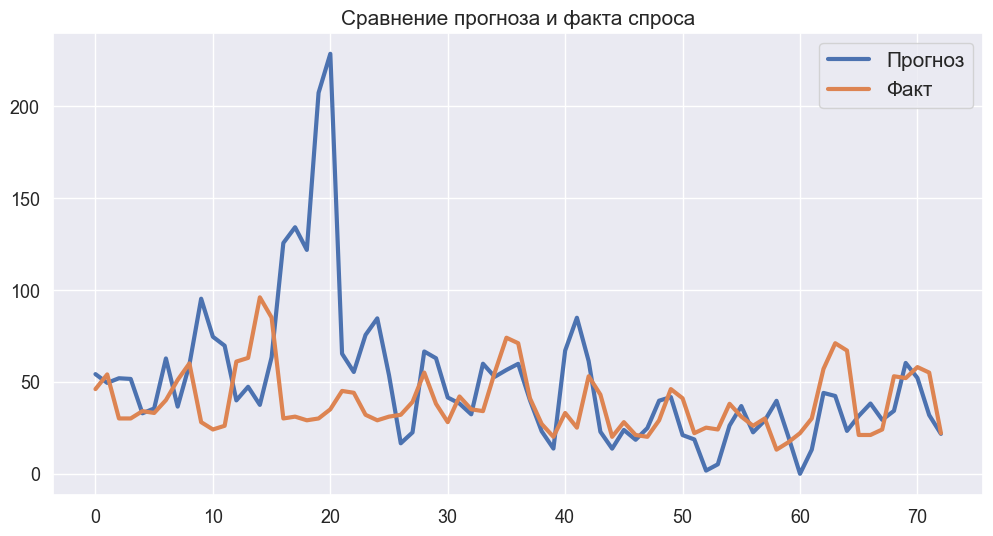

In [23]:
from matplotlib import pyplot as plt

#построим график
test_pred.plot(figsize=(10, 6), linewidth=3,
               fontsize=10, label='Прогноз')

test_cnt.plot(figsize=(12, 6), linewidth=3,
              fontsize=13, label='Факт')

plt.legend(fontsize=15)
plt.title('Сравнение прогноза и факта спроса', fontsize=15)
plt.show()

### Сделаем такое же предсказание, но теперь и для цены

MAE: 90.06
MAPE: 1.191


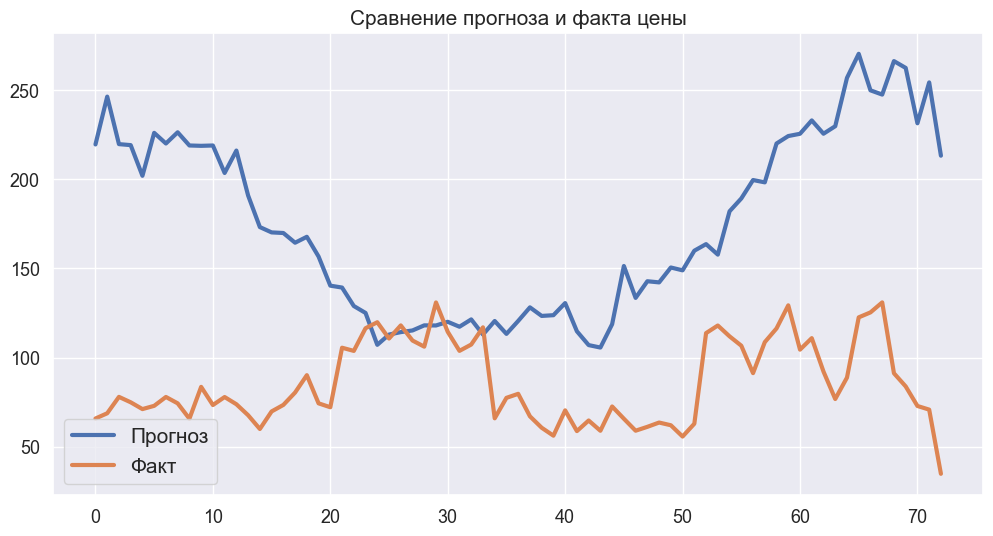

In [32]:
most_popular_product_tensor_price = data["8B76211744D54CE6EB125BE8611B29A7"]['prices']

train_prices, test_prices = split_tensor_for_time_series(most_popular_product_tensor_price)
train_prices = train_prices / 100
test_prices = test_prices / 100
time_series_model.fit(train_prices)

test_pred_prices = time_series_model.predict(test_prices)
mae = round(mean_absolute_error(test_prices, test_pred_prices), 2)
mape = round(mean_absolute_percentage_error(test_prices, test_pred_prices), 3)
print("MAE:", mae)
print("MAPE:", mape)

test_pred_prices.plot(figsize=(10, 6), linewidth=3,
               fontsize=10, label='Прогноз')

test_prices.plot(figsize=(12, 6), linewidth=3,
              fontsize=13, label='Факт')

plt.legend(fontsize=15)
plt.title('Сравнение прогноза и факта цены', fontsize=15)
plt.show()